In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import os
import copy
from drive.MyDrive.Assignment_4.fruit_360_small_dataset import fruit_360_small
from torch.utils.data import DataLoader
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
root_dir = "drive/MyDrive/Assignment_4/fruit_new"
image_transforms = transforms.Compose([transforms.RandomRotation((-270, 270)),
                                       transforms.Resize((224, 224))])
# perform rotation (-270 to 270 degrees) and resize transforms (224x224 pixels)

In [4]:
dataset = fruit_360_small(root_dir=root_dir, transform=image_transforms)
# create dataset by calling fruit_360_small and perform transforms

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


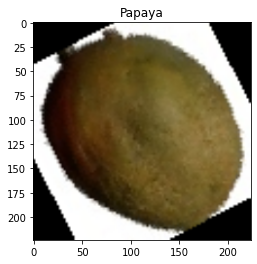

In [5]:
img, label = dataset[np.random.randint(len(dataset))]
print(type(img))
# print(img.size())
# print(img.unsqueeze(0).size())
img = img.permute(1, 2, 0)
plt.title(dataset.class_labels[label])
plt.imshow(img / 255.)
plt.show()
# test if image shows up

In [6]:
len(dataset)
# length of dataset

1953

In [7]:
val_size = 326
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)
# split dataset into training and validation sets

(1627, 326)

In [8]:
batch_size = 128
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size * 2, num_workers=4, pin_memory=True)

dataloaders = {'train': train_dl, 'val': val_dl}
# create dataloaders

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
# check device

device(type='cuda', index=0)

In [10]:
model = models.vgg16(pretrained=True)
model.to(device)
# import vgg16 model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
for param in model.parameters():
  param.requires_grad = False
# freeze parameters since we are using existing model

In [12]:
model.classifier[6] = nn.Linear(4096, 4)
model.to(device)
# change the outputs from 1000 to 4 (since we have 4 output classes)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# use the Adam optimizer for gradient descent

In [14]:
def train_model(model, criterion, optimizer, num_epochs=20):
  history = []
  # store losses and accuracies for each epoch in this list

  for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch+1, num_epochs))
    model.train()
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.
    correct_preds = 0
    # initialise necessary variables

    for batch in dataloaders['train']:
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # perform gradient descent when training  
        
      train_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      correct_preds += torch.sum(preds == labels.data)
      # update number of correct predictions and training loss

    epoch_train_loss = train_loss / len(dataloaders['train'].dataset)
    # total training loss per epoch
    epoch_train_acc = correct_preds.double() / len(dataloaders['train'].dataset)
    # total training accuracy per epoch

    correct_preds = 0

    with torch.no_grad():
      model.eval()
      # validation phase
      for batch in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
        # we don't perform loss.backward() since we don't update parameters during validation

      epoch_val_loss = val_loss / len(dataloaders['val'].dataset)
      epoch_val_acc = correct_preds.double() / len(dataloaders['val'].dataset)

    history.append([epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc])
    #print("Epoch: {:d}".format(epoch + 1, epoch_train_loss, epoch_train_loss, epoch_val_loss, epoch_val_acc))
    print("\nTraining: Loss:", epoch_train_loss, "Accuracy:", epoch_train_acc.item() * 100, "%\nValidation: Loss:", epoch_val_loss, "Accuracy:", epoch_val_acc.item() * 100, "%")
    print("-" * 20)
  return model, history

In [15]:
trained_model, history = train_model(model, criterion, optimizer, num_epochs=20)
# train the model

Epoch: 1/20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Training: Loss: 6.712259689722607 Accuracy: 42.28641671788568 %
Validation: Loss: 0.9399823308722374 Accuracy: 37.423312883435585 %
--------------------
Epoch: 2/20

Training: Loss: 2.7848453318039623 Accuracy: 67.42470805162876 %
Validation: Loss: 0.488249091282944 Accuracy: 48.46625766871166 %
--------------------
Epoch: 3/20

Training: Loss: 1.7691039884464097 Accuracy: 75.5377996312231 %
Validation: Loss: 0.26766317351464114 Accuracy: 47.85276073619632 %
--------------------
Epoch: 4/20

Training: Loss: 1.6545160197742745 Accuracy: 77.25875845113706 %
Validation: Loss: 0.33083426988929326 Accuracy: 46.625766871165645 %
--------------------
Epoch: 5/20

Training: Loss: 1.224754494322394 Accuracy: 81.56115550092193 %
Validation: Loss: 0.14860872092422533 Accuracy: 53.987730061349694 %
--------------------
Epoch: 6/20

Training: Loss: 1.1813012155639517 Accuracy: 80.82360172095882 %
Validation: Loss: 0.09359231819770088 Accuracy: 52.76073619631902 %
--------------------
Epoch: 7/20



In [16]:
trained_model.to(device)
# upload trained model to device

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
def predict(img, trained_model):
  img = img.unsqueeze(0).to(device)
  outputs = trained_model(img)
  _, preds = torch.max(outputs, 1)
  return test_dataset.class_labels[preds[0].item()]

# predict function to predict the image using the trained model

tensor([[-2.8350, -3.3191,  2.3875, -1.1150]], device='cuda:0',
       grad_fn=<AddmmBackward>)

tensor([2], device='cuda:0')
Label: Salak Predicted: Salak


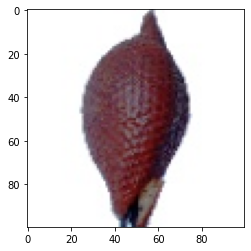

In [18]:
test_dataset = fruit_360_small(root_dir, train=False)
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img., trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Orange Predicted: Orange


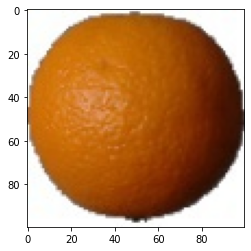

In [51]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Salak Predicted: Salak


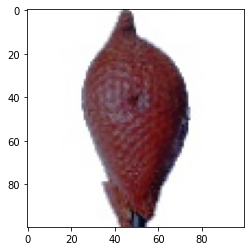

In [42]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Orange Predicted: Orange


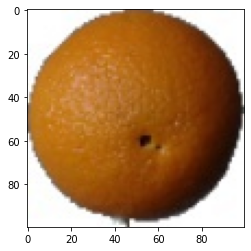

In [80]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Papaya Predicted: Papaya


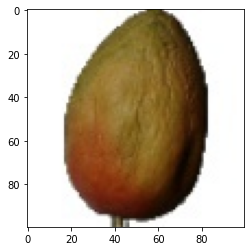

In [57]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Orange Predicted: Orange


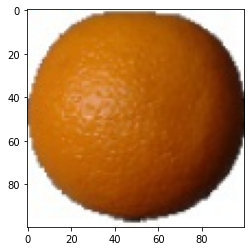

In [53]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Peach Predicted: Orange


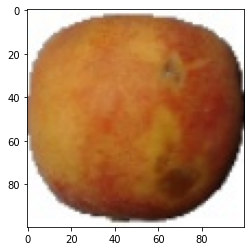

In [70]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()

Label: Papaya Predicted: Papaya


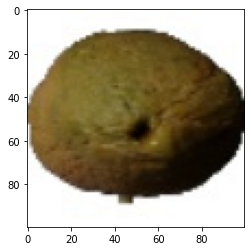

In [63]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
print('Label:', test_dataset.class_labels[label], 'Predicted:', predict(img, trained_model))
img = img.permute(1, 2, 0)
plt.imshow(img / 255.)
plt.show()